<a href="https://colab.research.google.com/github/Dmitry1937/RL/blob/main/DQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
START = False

## Loading libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,ReLU
from tensorflow.keras.layers import Dropout,Flatten,LeakyReLU,Dense, GlobalMaxPool2D
from tensorflow.keras.losses import MSE
import copy

from gym.wrappers import Monitor

In [ ]:
np.random.seed(98)

In [ ]:
pip install gym[atari]

In [ ]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


### Pretraning 

In [ ]:
#Вырежем лишнию информацию
def cut(s):
  s = s[34:-16:4,::2,:]
  s = s[:,:,1]
  s = s - s.min()
  s[s == 58] = 0 #other
  s = s/s.max()
  return s.reshape(40,80)

In [ ]:
#Вырежем лишнию информацию
def preparations(data):
  data = cut(data)
  return data.reshape(40,80,1)

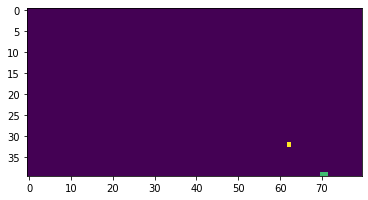

In [ ]:
s = preparations(env.reset())
for i in range(545):
  s_old =s
  s  = preparations(env.step(env.action_space.sample())[0])
  inp = np.concatenate((s,s_old,),axis = 2)

inp = np.array([inp])
_=plt.imshow(inp[0,:,:,0])


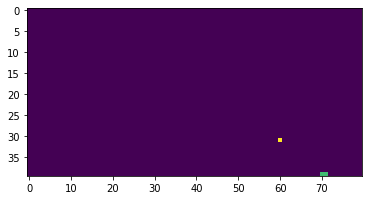

In [ ]:
_=plt.imshow(inp[0,:,:,1])

In [ ]:
#model_conv
input_shape =(40,80,2)
model_conv = tf.keras.Sequential([
    Flatten(input_shape=input_shape,),
    Dense(264, activation= 'relu',kernel_regularizer='l2', bias_regularizer= 'l2'),
    ],
    name = 'Convs'
          )

In [ ]:
model_conv.summary()

Model: "Convs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 264)               1689864   
Total params: 1,689,864
Trainable params: 1,689,864
Non-trainable params: 0
_________________________________________________________________


## DQN

### Preparation

In [ ]:
# get evaluations
def evalQ(input,model):
    inp = np.array([input])
    return model(inp).numpy()[0]

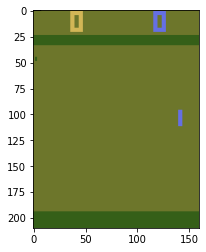

In [ ]:
s = env.reset()
_=plt.imshow(s)

In [ ]:
s_old = preparations(env.step(env.action_space.sample())[0])
s = preparations(env.step(env.action_space.sample())[0])

In [ ]:
s.shape

(40, 80, 1)

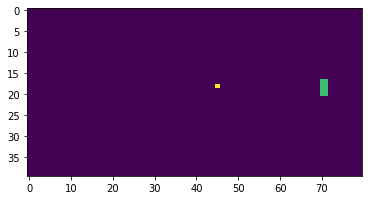

In [ ]:
s = preparations(env.reset())
for i in range(240):
  s_old =s
  s = preparations(env.step(env.action_space.sample())[0])
  inp = np.concatenate((s,s_old,),axis = 2)

inp = np.array([inp])
_=plt.imshow(inp[0,:,:,0])


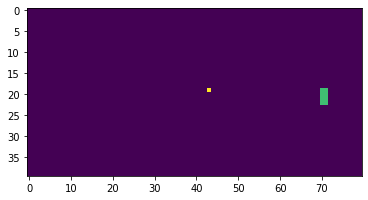

In [ ]:
_=plt.imshow(inp[0,:,:,1])

### Create DQN model

In [ ]:
#pretrening 
model_conv.trainable = True
model_dqn= tf.keras.Sequential([
    Dense(NUM_ACTIONS,activation='tanh'),
    ],
    name = 'DQN'
          )

model = tf.keras.Sequential([
          model_conv,
          model_dqn,
])

In [ ]:
if not START:
  model.load_weights('drive/MyDrive/Skillbox/current_weights.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convs (Sequential)           (None, 264)               1689864   
_________________________________________________________________
DQN (Sequential)             (None, 6)                 1590      
Total params: 1,691,454
Trainable params: 1,691,454
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def loss(q1, q2):
    loss1 = tf.reduce_sum(tf.square(q1 - q2))

    loss2 = tf.reduce_sum(tf.square(q1[:,2] - q1[:,4]) + tf.square(q1[:,3] - q1[:,5]) + tf.square(q1[:,0] - q1[:,1]))
    loss2 += tf.reduce_sum(tf.square(q2[:,2] - q2[:,4]) + tf.square(q2[:,3] - q2[:,5]) + tf.square(q2[:,0] - q2[:,1]))

    q1_n = q1 - tf.reduce_mean(q1,axis=1,keepdims=True)
    q2_n = q2 - tf.reduce_mean(q2,axis=1,keepdims=True)

    loss3 = tf.reduce_sum(tf.square(q1_n[:,2::2] + q1_n[:,3::2]) + tf.square(q2_n[:,2::2] + q2_n[:,3::2]))


    return 2*loss1 + loss2 + loss3

In [ ]:
# one  training step 
def model_step(d, t, ):
  #cutting the first 20 steps
  data = d[20::]
  data = np.array(data)

  target = t[20::]
  target = np.array(target)

  arr = np.arange(data.shape[0],)
  np.random.shuffle(arr)
  #print(data.shape[0])
  return data[arr], target[arr]

In [ ]:
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001 )
optimizer = tf.keras.optimizers.Adam( learning_rate=0.00001)
#optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam( learning_rate=0.01)
model.compile(loss=loss, optimizer=optimizer)

### Training 

In [ ]:
gamma = 0.99
def target_new(target, a, win = True):
  #Обучаемся только на последних 80 действиях
  long = 80
  if len(a) < long:
    long = len(a)
  if win:
    for i in range(-1,-long,-1):
        target[i][a[i]] =  1/long + target[i][a[i]]*gamma
    return target
  
  else:
    #Обучаемся только на последних 40 действиях
    long = 40
    if len(a) < long:
      long = len(a)
    for i in range(-1,-long,-1):
      #target[i][a[i]] = -1/long + target[i][a[i]]*gamma
      target[i][a[i]] = target[i][a[i]]*gamma
    return target

In [ ]:
lyamda = 2/3
if START:
  NUM_EPISODES = 50

  #Используем различный таргет для win и lost
  steck ={'data':[],'target':[],'a':[]}

  totalReward = -21
  bestReward = totalReward
  win = 0

  for i in range(NUM_EPISODES):

      eps = 1

      _ = preparations(env.reset())
      s_old = preparations(env.step(env.action_space.sample())[0])
      s = preparations(env.step(env.action_space.sample())[0])
      totalReward = 0
      step = 0
      done= False

      while not(done):
        step += 1
        inp = np.concatenate((s,s_old),axis = 2)
        #inp = np.array([inp],dtype=float)
        #inp = decoder(inp)
        Q_s = evalQ(inp,model)
        
        if np.random.rand() < eps:
            # Выбор случайного действия
            a = env.action_space.sample()
        else:
            # Выбор действия по текущей политике
            a = np.argmax(Q_s)
      
        # Сделать шаг
        s1, r, done, _ = env.step(a)
        s1 = preparations(s1)

        inp1 = np.concatenate((s1,s),axis = 2,)
        #inp1 = np.array([inp1],dtype=float)
        #inp1 = decoder(inp1)
        Q_s1 = evalQ(inp1,model)
        s,s_old = s1,s
        
        # Новое (целевое) значение Q-функции
        Q_target = Q_s

        # Обновление Q-функции
        if r ==0:
            Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]

            steck['data'].append(inp)
            steck['a'].append(a)
            steck['target'].append(Q_target)
        
        elif r ==-1:
            #Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]
            Q_target[a] = -(1-lyamda) + lyamda*Q_target[a]

            steck['data'].append(inp)
            steck['a'].append(a)
            steck['target'].append(Q_target)
            
            steck['target'] = target_new(steck['target'],steck['a'], win = False)
            data,target = model_step(steck['data'],steck['target'])
            if np.random.rand() < 0.1:
              model.train_on_batch(data, target)
            steck ={'data':[],'target':[],'a':[]}
        
        else :
            #Q_target[a] = -(1-lyamda) + lyamda*Q_target[a]
            Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]

            steck['data'].append(inp)
            steck['a'].append(a)
            steck['target'].append(Q_target)
            steck['target'] = target_new(steck['target'],steck['a'], win = True)
            
            data,target = model_step(steck['data'],steck['target'])
            model.train_on_batch(data, target)
            steck ={'data':[],'target':[],'a':[]}
        
        totalReward += r
        s = s1

        # Если конец эпизода
        if done:
            break
            
      if totalReward > -20:
        print('totalReward =', totalReward,'step =',step,'i =',i,'eps=',eps,)
        print('ex1=',target[-1])
        print('Q_s=',Q_s)


In [ ]:
if START:
    NUM_EPISODES = 5500

    #Используем различный таргет для win и lost
    steck ={'data':[],'target':[],'a':[]}

    totalReward = -21
    bestReward = totalReward
    win = 0

    for i in range(NUM_EPISODES):

        if totalReward > -21:
          eps = 0
        else:
          eps = 0.5

        _ = preparations(env.reset())
        s_old  = preparations(env.step(env.action_space.sample())[0])
        s = preparations(env.step(env.action_space.sample())[0])
        totalReward = 0
        step = 0
        done= False


        while not(done):
          step += 1
          inp = np.concatenate((s,s_old),axis = 2)
          #inp = np.array([inp],dtype=float)
          #inp = decoder(inp)
          Q_s = evalQ(inp,model)
          
          if np.random.rand() < eps:
              # Выбор случайного действия
              a = env.action_space.sample()
          else:
              # Выбор действия по текущей политике
              a = np.argmax(Q_s)
        
          # Сделать шаг
          s1, r, done, _ = env.step(a)
          s1 = preparations(s1)

          inp1 = np.concatenate((s1,s),axis = 2,)
          #inp1 = np.array([inp1],dtype=float)
          #inp1 = decoder(inp1)
          Q_s1 = evalQ(inp1,model)
          s,s_old = s1,s
          
          # Новое (целевое) значение Q-функции
          Q_target = Q_s

          # Обновление Q-функции
          if r ==0:
              Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]

              steck['data'].append(inp)
              steck['a'].append(a)
              steck['target'].append(Q_target)
          
          elif r ==-1:
              Q_target[a] = -(1-lyamda) + lyamda*Q_target[a]
              #Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]

              steck['data'].append(inp)
              steck['a'].append(a)
              steck['target'].append(Q_target)
              
              steck['target'] = target_new(steck['target'],steck['a'], win = False)
              data,target = model_step(steck['data'],steck['target'])
              model.train_on_batch(data, target)
              steck ={'data':[],'target':[],'a':[]}
          
          else :
              Q_target[a] = (1-lyamda)*np.max(Q_s1) + lyamda*Q_target[a]
              #Q_target[a] = (1-lyamda) + lyamda*Q_target[a]

              steck['data'].append(inp)
              steck['a'].append(a)
              steck['target'].append(Q_target)
              steck['target'] = target_new(steck['target'],steck['a'], win = True)
              
              data,target = model_step(steck['data'],steck['target'])
              model.train_on_batch(data, target)
              steck ={'data':[],'target':[],'a':[]}
          
          totalReward += r
          s = s1

          # Если конец эпизода
          if done:
              break
              
        if totalReward > -19:
          print('totalReward =', totalReward,'step =',step,'i =',i,'eps=',eps,'a=',a,)
          print('ex1=',target[-1])
          print('Q_s1=',Q_s1)
          print('Q_s=',Q_s)


## Let's play




In [ ]:
for i in range(10): 

    _ = preparations(env.reset())
    s_old = preparations(env.step(env.action_space.sample())[0])
    s = preparations(env.step(env.action_space.sample())[0])
    totalReward = 0
    step = 0
    done= False

    while not(done):
        step += 1

        inp = np.concatenate((s,s_old),axis = 2)
        Q_s = evalQ(inp,model)
        
        # Выбор действия по текущей политике
        a = np.argmax(Q_s)
       
        
        # Сделать шаг
        s1, r, done, _ = env.step(a)
        s1 = preparations(s1)

        s,s_old = s1,s

        
        totalReward += r
        s = s1
        
        # Если конец эпизода
        if done:
            break
    
    print('totalReward =', totalReward,'step =',step,'i =',i)


totalReward = -2.0 step = 4754 i = 0
totalReward = -7.0 step = 3983 i = 1
totalReward = -6.0 step = 3741 i = 2
totalReward = -9.0 step = 3990 i = 3
totalReward = -3.0 step = 4017 i = 4
totalReward = 1.0 step = 4683 i = 5
totalReward = 1.0 step = 4719 i = 6
totalReward = -4.0 step = 4164 i = 7
totalReward = 1.0 step = 4563 i = 8
totalReward = 3.0 step = 4482 i = 9


In [ ]:
if True:  
  !apt update 
  !apt install xvfb 

  !pip install pyvirtualdisplay 

  import pyvirtualdisplay

  display = pyvirtualdisplay.Display()
  display.start() 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

In [ ]:
'''if True: # Запустить этот блок нужно лишь один раз

    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install pyvirtualdisplay 

    from pyvirtualdisplay import Display
    #display = Display(visible=0, size=(1400, 900))
    display = pyvirtualdisplay.Display()
    display.start()'''

'if True: # Запустить этот блок нужно лишь один раз\n\n    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1\n    !pip install pyvirtualdisplay \n\n    from pyvirtualdisplay import Display\n    #display = Display(visible=0, size=(1400, 900))\n    display = pyvirtualdisplay.Display()\n    display.start()'

In [ ]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [ ]:
env_sim = Monitor(env, './video', force=True)

s = env_sim.reset()
totalReward = 0

_ = preparations(env.reset())
s_old = preparations(env.step(env.action_space.sample())[0])
s = preparations(env.step(env.action_space.sample())[0])

while True:
    env_sim.render()

    inp = np.concatenate((s,s_old),axis = 2)
    Q_s = evalQ(inp,model)

    a = np.argmax(Q_s)

    # Сделать шаг
    s1, r, done, _ = env_sim.step(a)
    s1 = preparations(s1)

    s,s_old = s1,s

    totalReward += r

    if done:        
        break
      
env_sim.close()

print('Total reward = {}'.format(totalReward))

Total reward = 5.0


In [ ]:
show_video()

video/openaigym.video.0.58.video000000.mp4
